<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-12.1" data-toc-modified-id="Figure-12.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 12.1</a></span></li><li><span><a href="#Figure-12.2" data-toc-modified-id="Figure-12.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 12.2</a></span></li><li><span><a href="#Figure-12.3" data-toc-modified-id="Figure-12.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 12.3</a></span></li><li><span><a href="#Figure-12.4" data-toc-modified-id="Figure-12.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 12.4</a></span></li><li><span><a href="#Figure-12.5" data-toc-modified-id="Figure-12.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 12.5</a></span></li><li><span><a href="#Figure-12.6" data-toc-modified-id="Figure-12.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 12.6</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 12
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import firls, filtfilt

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Extracting parameters from ./NeuralData/sampleEEGdata_convert.vhdr...
Setting channel info structure...
Reading 0 ... 63359  =      0.000 ...   247.496 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


C:\Users\goto\AppData\Local\Temp\ipykernel_5640\1147238205.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)


## Figure 12.1

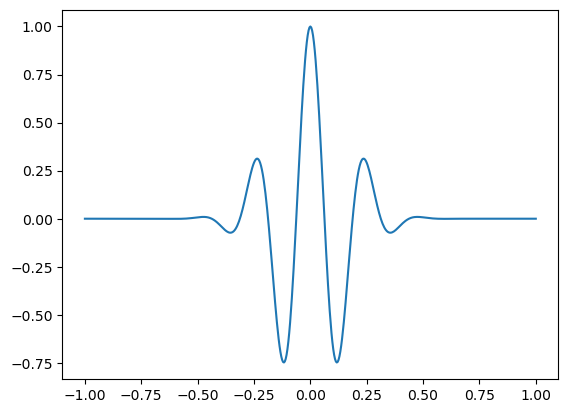

In [4]:
time = np.arange(-1,1+1/srate,1/srate)

f = 4 # frequency of sine wave in Hz

# create sine wave (actually, a cosine wave, for reasons that will become
# clear in Chapter 13)
sine_wave = np.cos(2*np.pi*f*time)

# Make a Gaussian

s = 4/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))

_=plt.plot(time,sine_wave*gaussian_win)

## Figure 12.2

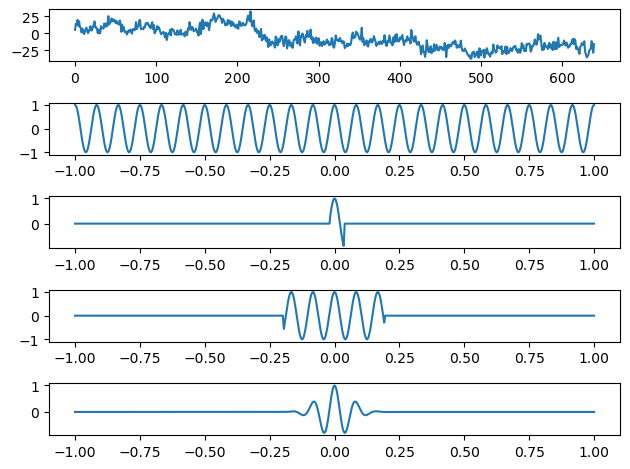

In [5]:
fig, ax = plt.subplots(5,1)
ax[0].plot(data[0,47,:])

sine_wave = np.cos(2*np.pi*12*time) # 12Hz cosine wave
ax[1].plot(time, sine_wave)

# boxcar envelope
boxcar = np.zeros(len(sine_wave))
midpoint = (len(time))//2
boxcar[midpoint-int(srate//12//5):midpoint+int(srate//12//2)] = 1
ax[2].plot(time, sine_wave*boxcar)

# boxcar envelope
boxcar = np.zeros(len(sine_wave))
midpoint = int(len(time))//2
boxcar[midpoint-50:midpoint+50] = 1
ax[3].plot(time, sine_wave*boxcar)

# redifine gaussian for new sine wave
s = 1.5/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))
ax[4].plot(time, sine_wave*gaussian_win)

fig.tight_layout()

## Figure 12.3

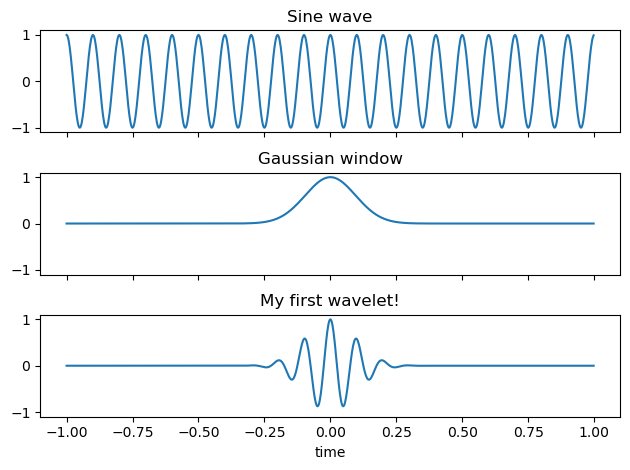

In [6]:
s_rate = 500                    # sampling rate in Hz
f = 10                          # frequency of the sine wave in Hz
time = np.arange(-1,1,1/s_rate)  # time, from -1 to 1 second in steps of 1/sampling-rate

sine_wave = np.exp(2*np.pi*1j*f*time) # complex wavelet (sine...?)

# Make a Gaussian
s = 6/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))

# and together they make a wavelet!
wavelet = sine_wave*gaussian_win

# make plots containing each component
fig, ax = plt.subplots(3,1,sharex='all', sharey='all')

ax[0].plot(time,np.real(sine_wave))
ax[0].set(title="Sine wave")

ax[1].plot(time,gaussian_win)
ax[1].set(title="Gaussian window")


ax[2].plot(time, np.real(wavelet))
ax[2].set(title="My first wavelet!", xlabel='time')

fig.tight_layout()

## Figure 12.4

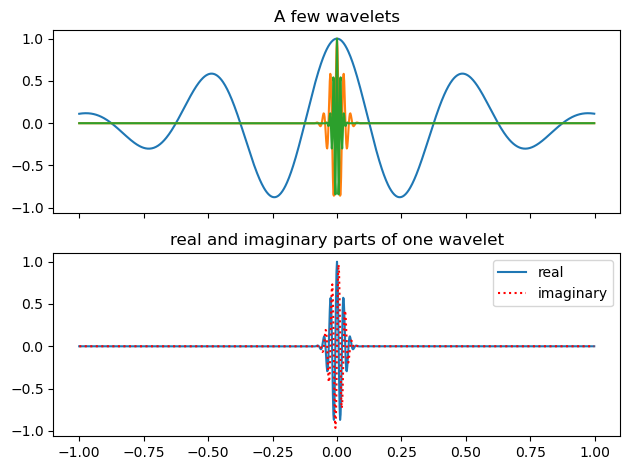

In [7]:
num_wavelets = 80            # number of frequency bands
lowest_frequency = 2         # in Hz
highest_frequency = 100      # in Hz

frequencies = np.linspace(lowest_frequency, highest_frequency, num_wavelets)


# initialize wavelet family
wavelet_family = np.zeros([num_wavelets,len(time)])*1j #1j is to create a complex array of zeros

# Loop through freqencies and make a family of wavelets.
for fi in range(num_wavelets):
    
    # create a sine wave at this frequency
    sinewave = np.exp(2*1j*np.pi*frequencies[fi]*time)
    
    # create gaussian window
    gaus_win = np.exp(-time**2/(2*(6/(2*np.pi*frequencies[fi]))**2))
    
    # create wavelet via element-by-element multiplying of the sinewave and the gaussian window
    wavelet_family[fi,:] = sinewave*gaus_win
    
    #  note that you can also do this on one line:
#    wavelet_family[fi,:] = exp(2*1j*pi*frequencies[fi]*time) * exp(-time**2/(2*(6/(2*pi*frequencies[fi]))**2))

fig, ax = plt.subplots(2,1,sharex='all', sharey='all')
#plot a few wavelets
ax[0].plot(time,np.real(wavelet_family[::int(np.random.rand()*30),:].T))
ax[0].set_title('A few wavelets')



ax[1].plot(time,np.real(wavelet_family[30,:]))
ax[1].plot(time,np.imag(wavelet_family[30,:]),'r:')
ax[1].set_title("real and imaginary parts of one wavelet")
plt.legend(["real","imaginary"])
plt.tight_layout()

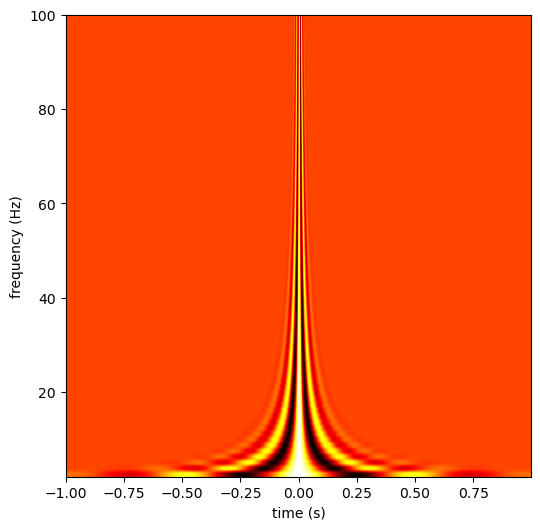

In [8]:
fig=plt.figure(figsize=(6,6))
plt.imshow(np.real(wavelet_family), 
           extent=[time[0], time[-1], frequencies[0], frequencies[-1]],
           aspect="auto",
           cmap=plt.get_cmap("hot"),
           origin="lower")

plt.xlabel("time (s)")
_=plt.ylabel("frequency (Hz)")

## Figure 12.5

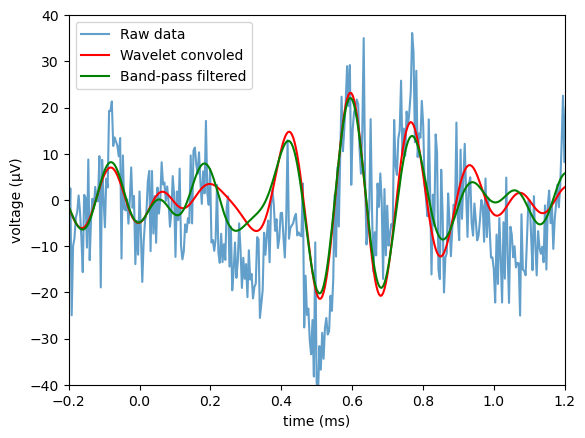

In [9]:
# EEG data from one trial (electrode FCz)
eegdata = data[9,46,:]

# create wavelet
time = np.arange(-1,1 + 1/srate,1/srate)
f = 6 # frequency of sine wave in Hz
sine_wave = np.exp(2*1j*np.pi*f*time)
s = 4.5/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))
wavelet = sine_wave * gaussian_win

# half of the wavelet size, useful for chopping off edges after convolution.
halfwaveletsize = len(wavelet)//2

# convolve with data
# compute Gaussian
n_conv = len(wavelet) + pnts - 1

fft_w = np.fft.fft(wavelet,n_conv)
fft_e = np.fft.fft(eegdata,n_conv)
ift = np.fft.ifft(fft_e*fft_w,n_conv)*np.sqrt(s)/10 # sqrt... is an empirical scaling factor that works here
wavelet_conv_data = np.real(ift[halfwaveletsize: - halfwaveletsize])

# create filter and apply to data 
# (more on how to interpret this code in a few chapters!)
nyquist = srate/2
transition_width = 0.2 # percent
filter_low = 4 # Hz
filter_high = 8 # Hz
ffrequencies = np.array([0 ,filter_low*(1-transition_width), 
                         filter_low, filter_high, filter_high*(1+transition_width), nyquist])/nyquist
ideal_response = np.array([0, 0, 1, 1, 0, 0])

filterweights = firls(np.round(3 * (1+srate / filter_low)), ffrequencies, ideal_response)
eeg_4to8 = filtfilt(filterweights, 1, eegdata)

plt.plot(times,eegdata, alpha=0.7)
plt.plot(times,wavelet_conv_data,'r')
plt.plot(times,eeg_4to8,'g')
plt.axis([-.2,1.2,-40,40])
plt.xlabel("time (ms)")
plt.ylabel("voltage (μV)")
_=plt.legend(["Raw data","Wavelet convoled","Band-pass filtered"])

## Figure 12.6

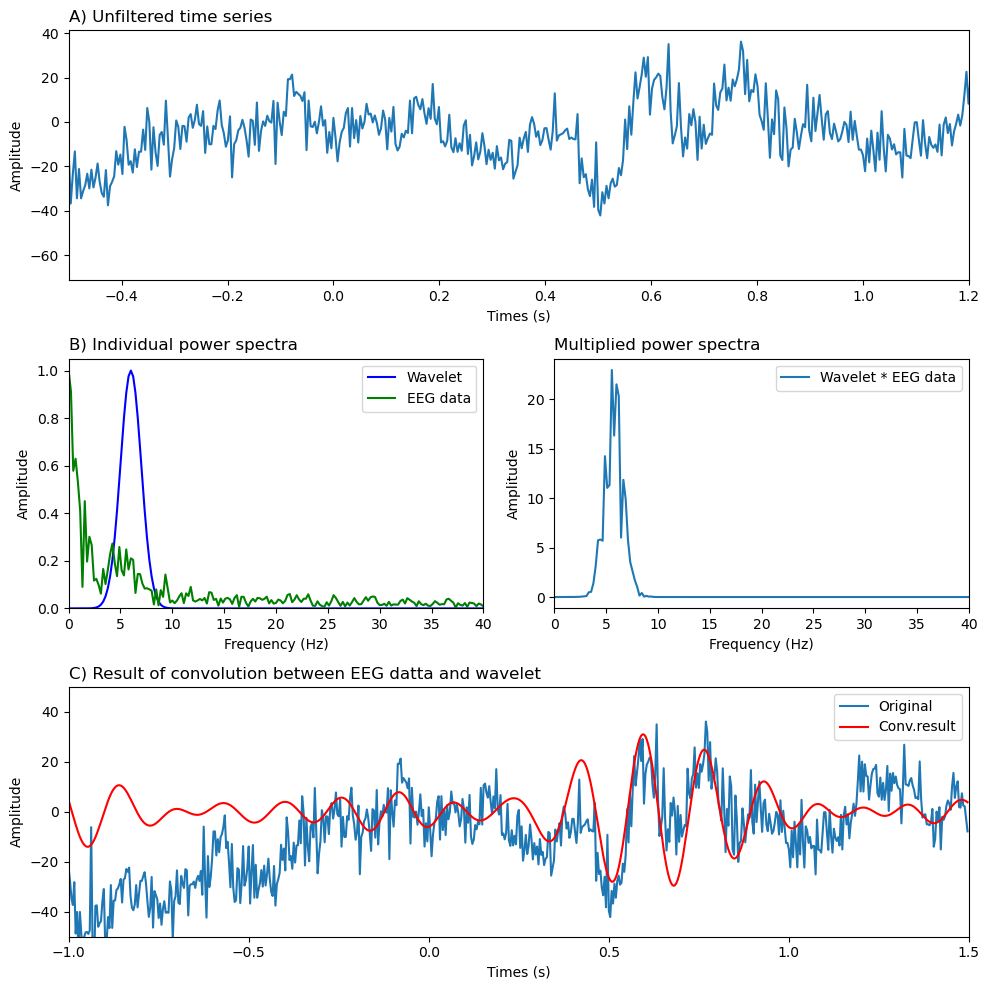

In [13]:
# make a theta-band-centered wavelet
time = np.arange(-1,1+1/srate,1/srate)
n_conv = pnts + len(time) -1
n2p1 = n_conv//2 + 1

f = 6
s = 6/(2*np.pi*f)
wavelet = np.exp(2 * np.pi * 1j *f * time) * np.exp(-time**2 / (2*s**2))
halfwaveletsize = len(wavelet)//2

eegdata = data[9, 46,:]

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(3, 1, 1)
plt.plot(times,eegdata)
plt.xlim([-.5,1.2])
plt.xlabel('Times (s)')
plt.ylabel('Amplitude')
plt.title("A) Unfiltered time series", loc='left')

plt.subplot(3, 2, 3)
fft_w = np.fft.fft(wavelet,n_conv)
hz    = np.linspace(0,srate/2.,n2p1)
plt.plot(hz, np.abs(fft_w[:n2p1]) / np.max(np.abs(fft_w[:n2p1])),'b')
fft_e = np.fft.fft(eegdata,n_conv)
plt.plot(hz, np.abs(fft_e[:n2p1]) / np.max(np.abs(fft_e[:n2p1])), 'g')
plt.axis([0, 40, 0, 1.05])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title("B) Individual power spectra", loc='left')
plt.legend(['Wavelet', 'EEG data'])

plt.subplot(3, 2, 4)
plt.plot(hz,np.abs(fft_e[:n2p1] * np.abs(fft_w[:n2p1]) / np.max(np.abs(fft_e[:n2p1]))))
plt.xlim([0, 40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title("Multiplied power spectra", loc='left')
plt.legend(['Wavelet * EEG data'])

plt.subplot(3, 1, 3)
plt.plot(times,eegdata)
ift = np.fft.ifft(fft_e*fft_w, n_conv)* np.sqrt(s)/10 #sqrt(s)/20 is empirical scaling factor (sqrt(s)/10 in the book)
plt.plot(times,np.real(ift[halfwaveletsize:-halfwaveletsize]),'r')
plt.ylim([-50,50])
plt.xlim([-1,1.5])
plt.xlabel('Times (s)')
plt.ylabel('Amplitude')
plt.title("C) Result of convolution between EEG datta and wavelet", loc='left')
plt.legend(['Original', 'Conv.result'])

plt.tight_layout()

In [ ]:
## Figure 12.7

In [ ]:
#create 10Hz wavelet (kernel)
time = np.arange(-(pnts / srate /2),pnts/srate/2 + 1/srate,1/srate)
f = 10 # frequency of sine wave in Hz
s = 4/(2*np.pi*f)
wavelet = np.cos(2 * np.pi * f * time) * np.exp(-time**2 / (2*s**2))

# signal is one sine cycle
timeS = np.arange(0,1/f + 1/srate,1/srate) # one cycle is 1/f
signal = np.sin(2*np.pi*f*timeS)

# now zero-pad signal
signal = np.concatenate([np.zeros(pnts//2 - len(timeS)//2), signal, np.zeros(pnts//2 - len(timeS)//2)])

plt.figure(figsize=(8,8))

#plot waves
plt.subplot(3, 2, 1)
plt.plot(wavelet,'r')
plt.xlim(200, len(time) - 200)
plt.title("A) A wavelet at 10 Hz")

plt.subplot(3, 2, 3)
plt.plot(signal)
plt.xlim([200, len(time)-200])
plt.title("B) One-cycle sine wave at 10 Hz")

plt.subplot(3, 2, 5)
plt.plot(np.convolve(wavelet,signal,mode="same"),'purple')
plt.axis([200,len(time)-200,-12,12])
plt.title("C) Result of convolution")

#plot the dot products at selected phase lags
plt.subplot(3, 2, 2)
plt.plot(wavelet[int(100/f)-2-1:],'--r', alpha=0.5)
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.title("D) Dot product dependts on relative phase")
plt.legend(["wavelet","signal"])
plt.text(355,-.25, 'dot product > 0')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 4)
plt.plot(wavelet[int(2.3*100/f)-2-1:],'--r', alpha=0.5)
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.text(355,-.25, 'dot product < 0')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2,6)
plt.plot(wavelet,'--r', alpha=0.5)
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.text(355,-.25, 'dot product = 0')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()